# Классификация MNIST полносвязной нейронной сетью

В этом практическом занятии мы рассмотрим задачу классификации изображений полносвязной нейронной сетью.

Мы будем решать классическую задачу распознавания рукописных цифр. Для этой задачи созан датасет MNIST. Он содержит в себе изображения (28x28 пикселей) рукописных цифр от 0 до 9 -- т.е. всего 10 классов картинок.

Далее посмотрим, как работает такая нейронная сеть для задачи распознавания изображений в датасетах CIFAR, которые являются набором реальных изображений, уменьшенных до размера 32x32 пикселей.

# Зафиксируйте генераторы случайных чисел

Генераторы случайных чисел генерируют различные наборы случайных чисел от запуска к запуску по умолчанию. Поскольку случайные числа используются для того, чтобы инициализировать веса сети и для того, чтобы выбирать примеры из обучающей выборки, то от запуска к запуску получившиеся нейронные сети будут отличаться.

Для того, чтобы решить эту проблему, необходимо инициализировать генераторы случайных чисел ```seed```-ами. Это делается следующими командами: ```random.seed``` для библиотеки ```random```, ```np.random.seed``` для библиотеки ```numpy```. Для pytirch же потребуется несколько команд:

```
torch.manual_seed_all
torch.cuda.manual_seed_all
```

Также потребуется переключить ```cuda``` в детерминированный режим:

```
torch.backends.cudnn.deterministic = True
```


In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

# Загрузите данные тренировочной и валидационной частей MNIST в память

Для этого используйте класс ```torchvision.datasets.MNIST```. Обратите внимание, что тренировочная и тестовая части задаются параметром ```train```.

In [2]:
import torchvision
from torchvision.datasets import MNIST

In [3]:
root="./mnist_dataset"
MNIST_train = torchvision.datasets.MNIST(root, train=True, download=True)
MNIST_test = torchvision.datasets.MNIST(root, train=False, download=True)

# Проверяем, что все работает

In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

print(X_train.shape, y_train.shape, '<- train dataset X and y')
print(X_test.shape, y_test.shape, '<- test dataset X and y')

print(X_train.dtype, y_train.dtype, '<- training data type')

torch.Size([60000, 28, 28]) torch.Size([60000]) <- train dataset X and y
torch.Size([10000, 28, 28]) torch.Size([10000]) <- test dataset X and y
torch.uint8 torch.int64 <- training data type


C:\Users\21218264\AppData\Roaming\Python\Python310\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\21218264\AppData\Roaming\Python\Python310\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\21218264\AppData\Roaming\Python\Python310\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\21218264\AppData\Roaming\Python\Python310\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Приводим форматы

PyTorch по умолчанию работает с тензорами, состоящими из float значений. Соответственно, необходимо привести тензоры с данными к float при помощи метода тензора ```.float()```. В качестве лосс-функции мы будем использовать ```torch.nn.CrossEntropy```, которая принимает на вход предсказания нейронной сети и тензор из номеров верных классов. Этот тензор должен быть в формте ```long```. Поскольку по умолчанию ```y``` в датасете уже в формате ```long```, то ничего делать с метками уже не нужно.

In [5]:
X_train=X_train.float()
X_test=X_test.float()

# Посмотрим на данные

Визуально оценим данные, которыми мы располагаем. Проверим, что разметка соответствует тому, что содержится на картинке. Для этого отобразим изображение при помощи ```plt.imshow``` и посмотрим, какой лейбл соответствует этому изображению.

Обратите внимание на этот код: в следующих заданиях делать отображения нужно будет самостоятельно.

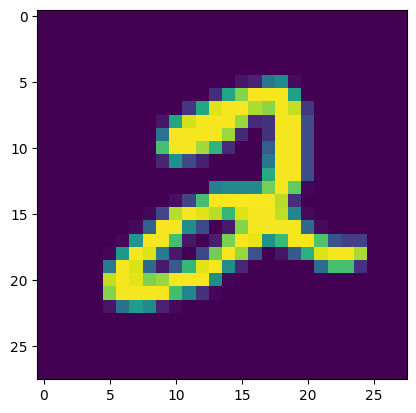

tensor(2)


In [6]:
import matplotlib.pyplot as plt

index = 5

plt.imshow(X_train[index, :, :])
plt.show()
print(y_train[index])

# Подготовим нейронную сеть

Для того, чтобы сделать нейронную сеть, которую будем обучать, необходимо сделать класс, унаследованный от ```pytorch.nn.Module```, в котором будут две функции:

* ```__init__(self, n_hidden_neurons)``` -- конструктор, в котором определим модули, которые будем использовать в нейронной сети. Перед обьявлением модулей, необходимо инициализировать родительский класс при помощи ```super().__init__()```, после чего можно будет обьявлять необходимые модули
Нейронная сетьв нашем случае будет состоять всего из трех модулей. Схематически нейронную сеть можно представить следующим образом:
```
torch.nn.Linear 28*28 -> n_hidden_neurons
torch.nn.LeakyReLU
torch.nn.Linear n_hidden_heurons -> 10
```

* ```forward(self, x)``` -- прямой проход сети. Здесь необходимо из ```x``` получить прогнозы. ```x``` -- это батч из картинок, преобразованных в вектор. Батч -- тензор размера ```N x 784```, где ```N``` -- число изображений в батче, ```784``` -- число пикселей в черно-белом изображении ```28 x 28```. Примените ко входным данным ```x``` метод ```reshape([-1, 784])``` (```-1``` означает, что второе измерение должно быть размера 784, а первое -- чему получится). Затем последовательно примените модули, обьявленные в конструкторе и верните полученный сигнал.

In [7]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.Linear = torch.nn.Linear(28*28, n_hidden_neurons)
        self.LeakyReLu = torch.nn.LeakyReLU()
        self.Linear2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = x.reshape([-1, 784])
        x = self.Linear(x)
        x = self.LeakyReLu(x)
        res = self.Linear2(x)
        return res


# Проверим, что все сделано верно

In [8]:
mnist_net = MNISTNet(100)
res = mnist_net(torch.zeros(10, 28*28))
assert res.shape[0] == 10
print(res.shape, '<- shape of predictions')

torch.Size([10, 10]) <- shape of predictions


# Зададим лосс-функцию и оптимизатор

В качестве лосс-функции будем использовать ```torch.nn.CrossEntropyLoss```

В качестве оптимизатора будем использовать ```torch.nn.Adam```

Оптимизатор должен оптимизировать все параметры нейронной сети (ссылку на которые можно получить при помощи метода ```mnist_net.parameters()```) и скорость обучения необходимо выставить равной $10^{-3}$.

In [9]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

# Сделаем процесс обучения

Все готово: оптимизатор, лосс-функция, нейронная сеть. Осталось обучить нейронную сеть.

Для этого нужно создать цикл обучения.

Цикл обучения обычно состоит из двух вложенных циклов: внутренний цикл обеспечивает проход по всем примерам из обучающей или тестовой выборки. Один такой проход называется эпохой.

Внешний же цикл обеспечивает повторение эпох.

# Инструкции по построению цикла обучения

* Сделайте внешний цикл из заранее заданного количества итераций, в котором:
  * Сгененрируйте случайный порядок следования обучающих примеров при помощи метода ```order = np.random.permutation(...)```
  * Сделайте внутренний цикл по обучающим примерам. Цикл должен терироваться по ```order``` с интервалом ```batch_size``` (```range(0, len(order), batch_size)```), в котором:
    * Получите индексы обучающих примеров для текущего шага, сделав слайсинг ```indice = order[start_index:start_index+batch_size]```.
    * Далее из обучающих примеров и лейблов нужно выбрать соответствующие примеры и лейблы при помощи индексации (```X_batch = X[indice]```).
    * Теперь мы готовы к тому, чтобы получить предсказания нейронной сети. Если вы используете батч-нормализации, то здесь нужно переключить сеть в тренировочный режим (```net.train()```)
    * Получите предсказания для полученного батча при помощи нейронной сети (```batch_preds = net(X_batch)```).
    * Рассчитайте значение лосс функции исходя из предсказаний и лейблов батча
    * Обнулите градиенты, накопленные в узлах нейронной сети, которые будут оптимизироваться (```optimizer.zero_grad()```).
    * Рассчитайте градиенты лосс-функции по параметрам нейронной сети ```loss.backward()```
    * Сделайте шаг оптимизатора (```optimizer.step()```).
    * Если вы используете батч-нормализации или DropOut, переключите нейронную сеть в валидационный режим (```net.valid()```).

  * Рассчитайте предсказания для тестовой выборки (в нашем случае это можно сделать одним батчем, ```test_preds = net(X_test)```)
  * Рассчитайте точность для тестовой выборки.
  * Рассчитайте лосс-функцию для тестовой выборки.
  * Добавьте рассчитанную точность в историю точности и лосс в историю лоссов


In [10]:
batch_size = 100
n_epochs = 100

train_loss_history = []
train_accuracy_history = []

test_accuracy_history = []
test_loss_history = []

for epoch in range(n_epochs):
    mnist_net.train() #aboba
    order = np.random.permutation(len(X_train))
    correct = 0
    samples = 0
    loss1 = 0.0
    loss_test = 0.0

    for item in range(0, len(order), batch_size):
        indice = order [item:item+batch_size]
        X_batch=X_train[indice]
        #mnist_net.train()        
        batch_preds = mnist_net(X_batch)
        loss1 = loss(batch_preds, y_train[indice])
        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()
        X_pred = mnist_net(X_batch)
        _, train_predicted = torch.max(X_pred, 1)
        #mnist_net.eval()
        correct+=torch.sum(train_predicted == y_train[indice])
        samples+=y_train[indice].size(0)

    accuracy = 100 * correct/samples
    train_accuracy_history.append(accuracy)
    
    test_preds = mnist_net(X_test)
    train_loss_history.append(loss1.detach().numpy())

    loss_test = loss(test_preds, y_test)
    test_loss_history.append(loss_test.detach().numpy())

    test_acc = torch.sum(torch.argmax(test_preds, dim=1) == y_test)

    test_accuracy_history.append(100*test_acc / len(y_test))
    



# Построим график прогресса обучения

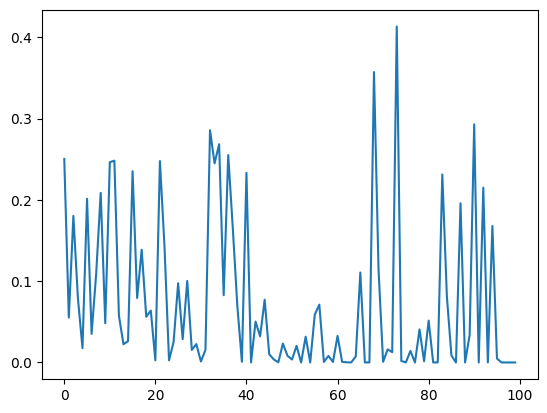

In [11]:
plt.plot(train_loss_history)
#plt.plot(test_loss_history)

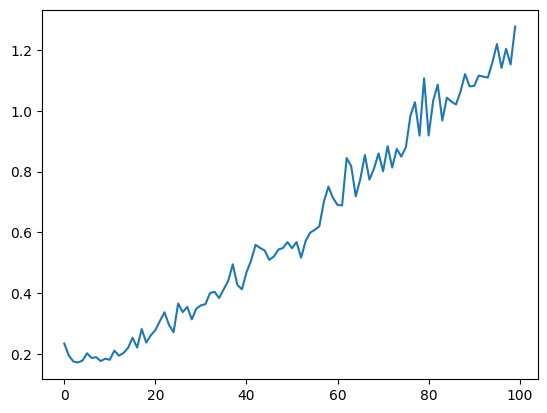

In [12]:
plt.plot(test_loss_history)

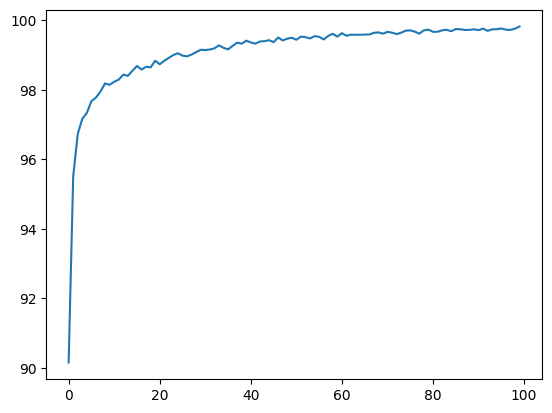

In [13]:
plt.plot(train_accuracy_history)


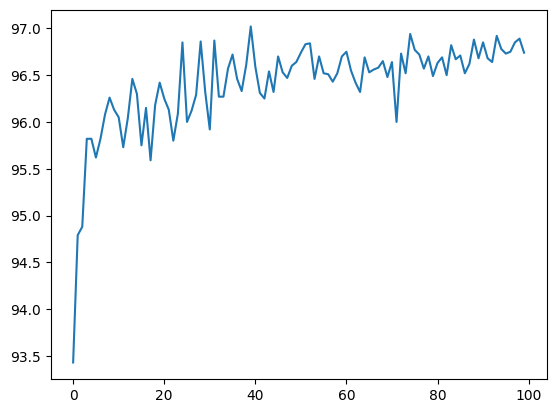

In [14]:
plt.plot(test_accuracy_history)

# Послесловие

Вы сделали ваш первый цикл обучения самостоятельно. Он довольно простой и лаконичный, занимает не больше 100 строк и его достаточно просто переписать. В этот цикл обучения можно добавлять все больше и больше функционала. В результате цикл обучения станет очень большим и нечитаемым, логику внутри цикла будет достаточно непросто понять.

Для того, чтобы не задумываться о циклах обучения, были разработаны библиотеки для упрощения обучения нейронных сетей такие, как PyTorch Lightning. Мы познакомимся с PyTorch Lightning в следующем практическом задании.